In [1]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors

from qiskit import QuantumCircuit, transpile
import numpy as np

In [2]:
def dj_function(num_qubits, balanced=True):
    qc = QuantumCircuit(num_qubits + 1)
    
    if balanced:
        # Create a constant function
        if np.random.randint(0, 2):
            qc.x(num_qubits)  # Flip output qubit with 50% chance
    else:
        # Create a balanced function
        qc.x(num_qubits)

        # Choose half the possible input states
        on_states = np.random.choice(
            range(2**num_qubits),  # numbers to sample from
            2**num_qubits // 2,  # number of samples
            replace=False,  # makes sure states are only sampled once
        )

        def add_cx(qc, bit_string):
            for qubit, bit in enumerate(reversed(bit_string)):
                if bit == "1":
                    qc.x(qubit)
            return qc

        for state in on_states:
            qc.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
            qc = add_cx(qc, f"{state:0b}")
            qc.mcx(list(range(num_qubits)), num_qubits)
            qc = add_cx(qc, f"{state:0b}")

    qc.barrier()
    return qc


In [3]:
def create_noise_model(f):
    noise_model = NoiseModel()

    # Add a bit-flip error on all single-qubit gates with a probability of 0.05
    bit_flip_error = errors.pauli_error([('X', f), ('I', 1-f)])
    noise_model.add_all_qubit_quantum_error(bit_flip_error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])

    # Add a phase-flip error on all single-qubit gates with a probability of 0.05
    phase_flip_error = errors.pauli_error([('Z', f), ('I', 1-f)])
    noise_model.add_all_qubit_quantum_error(phase_flip_error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])
    
    # Add a depolarizing error on two-qubit gates with a probability of 0.05
    depolarizing_error = errors.depolarizing_error(f, 2)
    noise_model.add_all_qubit_quantum_error(depolarizing_error, ['cx'])

    return noise_model

In [4]:
def compile_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    # qc.x(n)  # bug
    qc.x(n)      #1
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)   #2
    qc.h(range(n))        #3
    # qc.x(0)  # bug
    qc.measure(range(n), range(n))
    return qc

In [5]:
def dj_algorithm(function: QuantumCircuit, noise, shots):
    qc = compile_circuit(function)
    # print("dj_algorithm")
    # qc.draw('mpl')
    simulator = AerSimulator(noise_model=noise)
    result = simulator.run(transpile(qc, simulator), shots=shots, memory=True).result()
    # measurements = result.get_memory()
    return result.get_counts()

In [6]:
from math import log2

def calculate_bias_entropy(output_map, unwanted_states):
    total_count = sum(output_map.values())

    bias = 0
    count = 0
    for key, val in output_map.items():
        if key in unwanted_states:
            bias += val / total_count
        count += 1

    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return bias, entropy

In [7]:
def to_bin(number, num_bits):
    return format(number, f'0{num_bits}b')

In [13]:
n=3
unwanted_cons = [to_bin(0,n)]
unwanted_bal = [to_bin(i,n) for i in range(1, pow(2,n))]
unwanted = {'balanced': unwanted_bal,
            'constant': unwanted_cons}
shots=1000
runs=1000

In [14]:
def empty_dict():
    dict = {}
    keys = unwanted_cons+unwanted_bal
    dict = dict.fromkeys(keys, 0)
    return dict

# Count Histogram

0.028761 2.9140039363776205


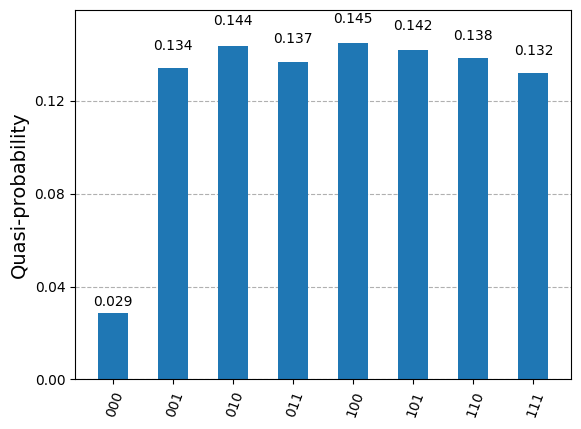

In [16]:
dist = empty_dict()
noise = create_noise_model(0.001)
f_type = 'constant'
for _ in range(runs):
    f = dj_function(n, balanced=(f_type=='balanced'))
    result = dj_algorithm(f, noise, shots)
    for key, val in result.items():
        dist[key] += val

arr = calculate_bias_entropy(dist, unwanted[f_type])   # the second argument is a list of unwanted states
print(arr[0], arr[1])
for key, val in dist.items():
    dist[key] = val/(shots*runs)
plot_histogram(dist)

# Plot of Entropy wrt Noise

In [ ]:
entropies = []
biases = []
noise_levels = [j/100.0 for j in range(0, 51)]
f_type='balanced'
for i in noise_levels:
    dist = empty_dict()
    noise_model = create_noise_model(i)
    for _ in range(runs):
        f = dj_function(n, balanced=(f_type=='balanced'))  #bal
        result = dj_algorithm(f, noise_model, shots)
        for key, val in result.items():
            dist[key] += val
    arr = calculate_bias_entropy(dist, unwanted[f_type])
    biases.append(arr[0])
    entropies.append(arr[1])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(noise_levels, entropies, marker='o')  # marker='o' adds points for each x-y pair
plt.xlabel('noise_level')
plt.ylabel('entropy')
plt.title('Plot of Entropy vs Noise')
plt.grid(True)
plt.show()